In [1]:
import os
import cv2
import numpy as np
from sklearn import preprocessing
def train_data(data_path,eigen_faces_num):
    train_images = []
    images = []
    for filename in os.scandir(data_path):
        if filename.is_file():
            img = cv2.imread(filename.path,cv2.IMREAD_GRAYSCALE)
            images.append(filename.path)
            flatten_img = img.flatten()
            train_images.append(flatten_img)
    train_images = np.array(train_images)
    mean_img = np.sum(train_images,axis=0,dtype='float64')/train_images.shape[0]
    zero_mean_train = train_images - mean_img
    cov_matrix = zero_mean_train.dot(zero_mean_train.T)/train_images.shape[0]
    eigenvalues,eigenvectors = np.linalg.eig(cov_matrix)
    indices = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:,indices]
    images_projection = zero_mean_train.T.dot(eigenvectors)
    eigen_faces = preprocessing.normalize(images_projection.T)
    projections = []
    for i in range(train_images.shape[0]):
        projections.append(eigen_faces[:eigen_faces_num].dot(zero_mean_train[i]))
    return projections,mean_img,eigen_faces,images

In [2]:
import math
def recog_face(test_path,projections,mean_img,eigen_faces,images,eigen_faces_num,thres):
    test = cv2.imread(test_path,cv2.IMREAD_GRAYSCALE)
    flatten_test = test.flatten()
    zero_mean_test = flatten_test - mean_img

    E = eigen_faces[:eigen_faces_num].dot(zero_mean_test)
    test_projected = eigen_faces[:eigen_faces_num].T.dot(E)
    diff = zero_mean_test-test_projected
    beta = math.sqrt(diff.dot(diff))
    #if beta<thres:
    #        print("Face Detected in the image!")
    #else:
    #    print("No face Detected in the image!")
    smallest_dist = None # to keep track of the smallest value
    img_idx = 0 #to keep track of the class that produces the smallest value
    #Calculate and represent the vectors of the image in the dataset
    for z in range(len(projections)):
        diff = E-projections[z]
        imgs_dist = math.sqrt(diff.dot(diff))
        if smallest_dist==None:
                smallest_dist=imgs_dist
                img_idx = z
        if smallest_dist>imgs_dist:
            smallest_dist=imgs_dist
            img_idx=z
    return images[img_idx]


In [3]:

def sen_spec(ls,cls,h):
    # tn
    newarr = np.ones((h,h))
    newarr[cls][:] = 0
    for i in range(h):
        newarr[i][cls] = 0
    tn = np.sum(np.array(ls) * np.array(newarr))

    #fp
    newarr = np.zeros((h,h))

    for i in range(h):
        if i !=cls:
            newarr[i][cls] = 1
    fp = np.sum(np.array(ls) * np.array(newarr)) 

    #fn
    newarr = np.zeros((h,h))
    for i in range(h):
        if i !=cls:
            newarr[cls][i] = 1
    fn = np.sum(np.array(ls) * np.array(newarr))

    #tp
    tp = ls[cls][cls]
    sensitivity = tp/(tp+fn)
    spec = tn/(tn+fp)
    #print(spec,sensitivity)
    #print(tp,tn,fp,fn)
    return sensitivity,(1-spec)


1.0
0.7857142857142857
0.9761904761904762
0.9523809523809523


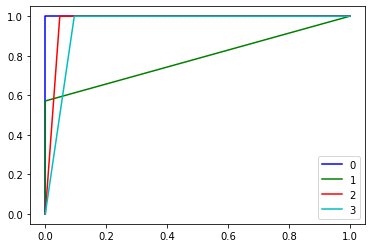

In [4]:
import re
c = ['b','g','r','c']
import matplotlib.pyplot as plt
x= []
y=[]
xfin=[]
yfin=[]
lst= np.zeros((4,4))
for n in range(0,4):
    x.append(0)
    y.append(0)
    for m in range(10,10000,50):
        projections,mean_img,eigen_faces,images = train_data("Dataset/train",m)
        for filename in os.scandir("Dataset/test"):
            if filename.is_file():
                actual = filename.path
                pred = recog_face(actual,projections,mean_img,eigen_faces,images,m,1000)
                act_ind =int(re.findall('[0-4]+', actual)[0])
                pred_ind =int(re.findall('[0-4]+', pred)[0])
                lst[act_ind][pred_ind] = lst[act_ind][pred_ind] + 1      #  actual pred
        np.savetxt('test.out', lst, delimiter='\t')
        sen,specs = sen_spec(lst,n,4)
        x.append(specs)
        y.append(sen)
        lst= np.zeros((4,4))
    x.append(1)
    y.append(1)
    xfin.append(x)
    yfin.append(y)
    plt.plot(x,y,color=c[n],label=str(n))
    print(np.trapz(y,x, axis=0))
    x=[]
    y=[]

plt.legend()
plt.show()
